In [1]:
import sys
assert sys.version_info >= (3, 6), "Python 3.6 required for this notebook."

In [2]:
# get latest version of packages
! pip install --upgrade pandas sklearn seaborn jupyterthemes tqdm statsmodels dcor tslearn

Requirement already up-to-date: pandas in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.23.1)
Requirement already up-to-date: sklearn in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.0)
  Using cached https://files.pythonhosted.org/packages/bc/ee/1921d0f873bd56fca378ad938eaff7cc2ab3e622ed6c035d968924c17677/jupyterthemes-0.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/29/df/1f8233500d8bb90f16fd066560f3805197e568af611ca97eddd5fb81b012/statsmodels-0.9.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
Requirement already up-to-date: dcor in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.1.5)
Requirement already up-to-date: tslearn in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.1.18.3)
Requirement not up

In [3]:
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from jupyterthemes import jtplot
from numpy.random import seed
from pandas.plotting import parallel_coordinates

jtplot.style(theme='grade3', ticks=True, grid=False, figsize=(20, 12))

In [4]:
data_file = "../data/time_series_bonds.xlsx"

In [5]:
data = pd.read_excel(data_file, sheet_name="d").set_index("date")
nrows, ncols = data.shape
print(f"Loaded {nrows} rows x {ncols} series")

Loaded 556 rows x 200 series


In [6]:
# interpolation for missing values
holed_series = np.array([i if i != 0.0 else np.nan for i in data['n1']])
interpolated = pd.Series(holed_series).interpolate()
interpolated.index = data.index
data['n1'] = interpolated

## Hierarchical approach

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [8]:
link = linkage(data, metric='correlation')

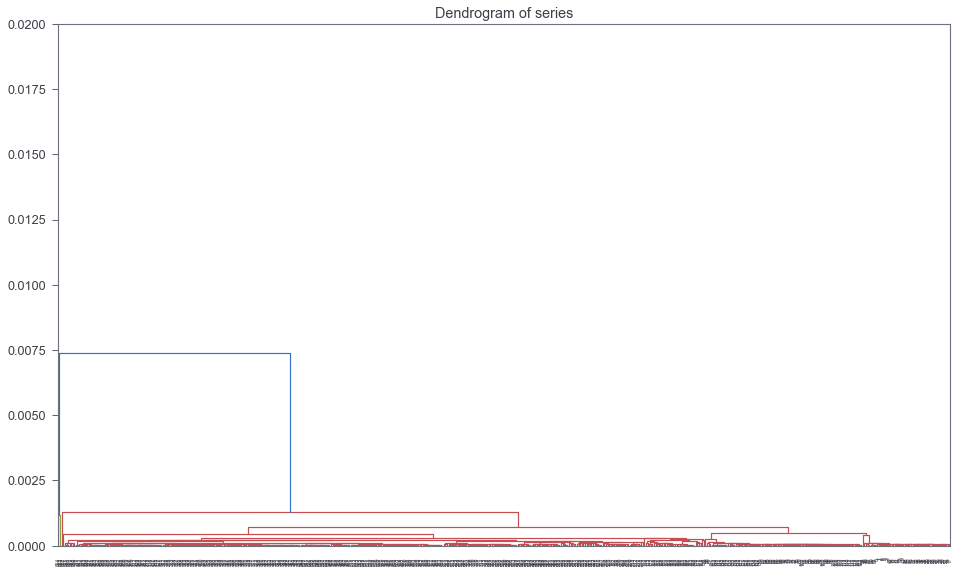

In [9]:
dendrogram(link)
plt.ylim(0, 0.02)
plt.title("Dendrogram of series")
plt.show()

Given the number of series in the dataset it is not easy to determine a cluster composition based on the dendrogram.

Hierarchical approach is probably not suitable to approach this problem.

## Timeseries approach
There are different approaches that can be used to measure timeseries similarity and use that information as metric to define clusters.

### Correlation

GMM
DBSCAN
BIRCH
MEANSHIFT
KMeans


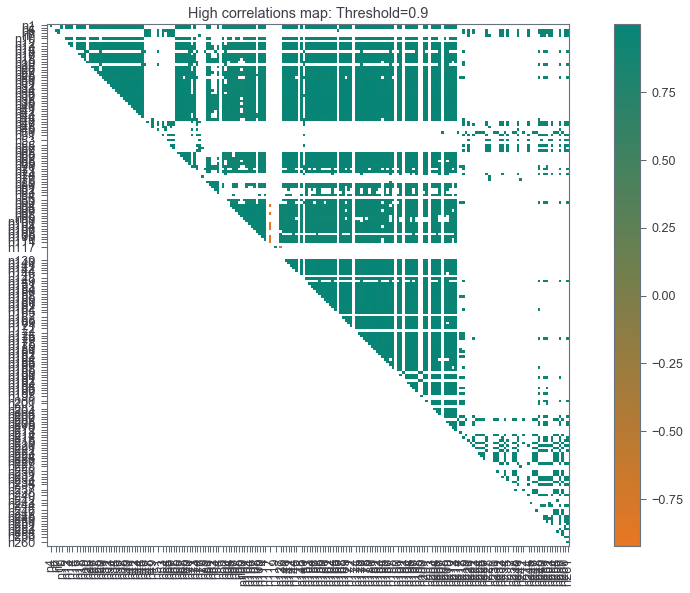

In [10]:
sys.path.append(".")
import utilities
utilities.plot_correlations(data, 0.9)

The graph above shows series that are higly correlated with each other. The threshols chosen is $0.9$. A lot of series are higly correlated, and in some cases might even be Granger-causing others.

Correlation, however is not the best estimator in presence of non-linear dependencies. Distance correlation, however, was developed to address the shortcomings of Pearson correlation, and might yield results that better represent the data.

# Timeseries approach
Some standards algorithms like Kmeans can be applied to timeseries with a little adaptation.  
In this section, timeseries KMeans is applied to the data to verify the goodness of the separation.

## Number of clusters

In [11]:
import tslearn

In [12]:
from tslearn import utils, clustering

In [13]:
series = tslearn.utils.to_time_series_dataset(data.T.values)

In [32]:
seed(1)
scores = list()

for i in tqdm.tqdm_notebook(range(4, 51)):
    tskm = clustering.TimeSeriesKMeans(n_clusters=5, metric="euclidean")
    pr = tskm.fit_predict(series)
    s = tslearn.clustering.silhouette_score(series.reshape(200, 556), pr, metric="euclidean")
    scores.append((i, s))

2912.564 --> 1791.726 --> 1756.685 --> 1740.416 --> 1732.378 --> 1729.501 --> 1729.501 --> 
2180.600 --> 1992.931 --> 1992.931 --> 
2692.553 --> 2022.019 --> 1854.640 --> 1790.450 --> 1758.576 --> 1746.569 --> 1746.569 --> 
2098.267 --> 1768.918 --> 1733.979 --> 1732.174 --> 1732.174 --> 
3448.451 --> 2069.660 --> 2021.041 --> 2013.519 --> 2005.014 --> 2004.444 --> 2004.444 --> 
2133.977 --> 1767.480 --> 1706.966 --> 1690.798 --> 1686.802 --> 1675.281 --> 1675.281 --> 
2598.044 --> 2114.350 --> 1951.214 --> 1838.066 --> 1787.596 --> 1755.292 --> 1746.569 --> 1746.569 --> 
2583.623 --> 1884.462 --> 1753.196 --> 1748.575 --> 1748.575 --> 
2124.536 --> 1771.915 --> 1729.802 --> 1705.271 --> 1690.798 --> 1686.802 --> 1675.281 --> 1675.281 --> 
2007.106 --> 1774.858 --> 1752.758 --> 1748.997 --> 1746.569 --> 1746.569 --> 
2161.306 --> 1786.498 --> 1765.381 --> 1748.997 --> 1746.569 --> 1746.569 --> 
2899.490 --> 2606.356 --> 2452.937 --> 2183.201 --> 1929.201 --> 1780.524 --> 1756.685 --> 1

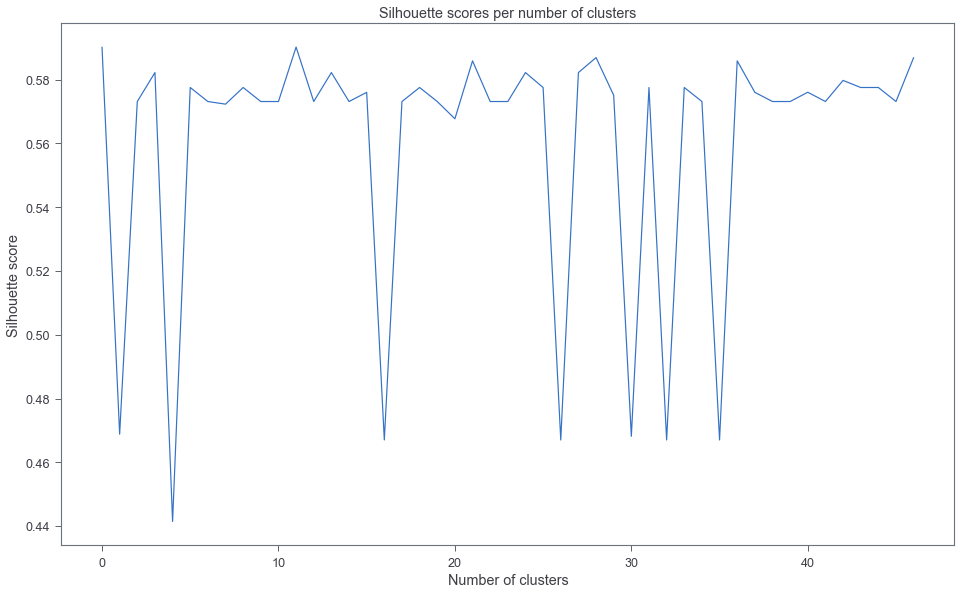

In [33]:
plt.plot([j for _, j in scores])
plt.title("Silhouette scores per number of clusters")
# plt.ylim(0.54, 0.55)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

Based on the scores obtained, there are some optimal configurations for clusters (although the score is not very high). There are also a few sub-optimal configurations.

The simplest best model can be obtained from the maximum score (reality is more complex, but this is a relatively good approximation).

In [34]:
sc = np.array([j for _, j in scores])
best_clusters = np.argwhere(sc == sc.max())

In [35]:
np.array(scores)[best_clusters.reshape(1, -1)]

array([[[ 4.        ,  0.59024818],
        [15.        ,  0.59024818]]])

In [36]:
km = tslearn.clustering.TimeSeriesKMeans(n_clusters=15, metric="euclidean")

In [37]:
x = km.fit_predict(series)

528.927 --> 337.892 --> 315.798 --> 315.270 --> 314.917 --> 314.349 --> 314.115 --> 314.115 --> 


In [38]:
import collections

clusters_counts = collections.Counter(x)

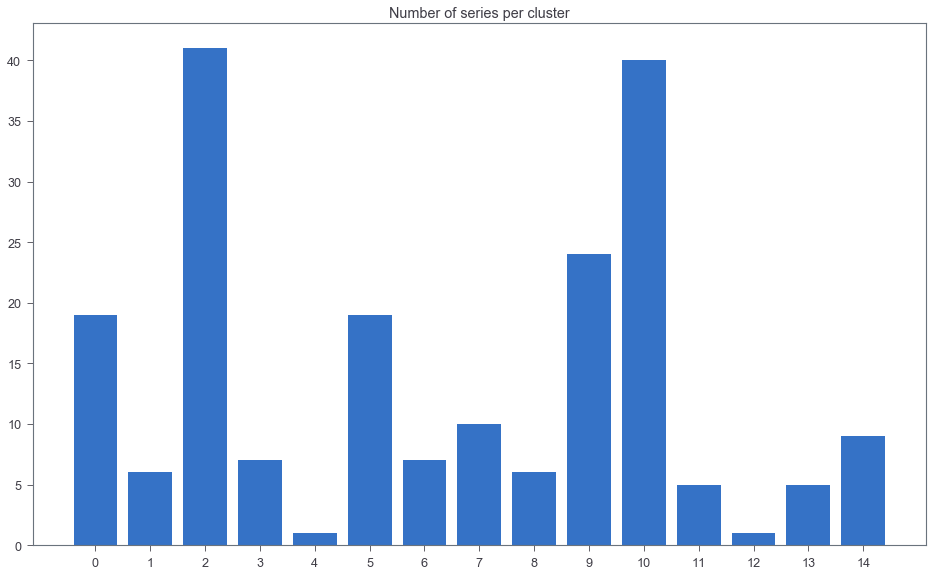

In [39]:
bars = [clusters_counts[i] for i in range(len(clusters_counts))]

plt.bar(range(len(clusters_counts)), bars)
plt.xticks(range(len(clusters_counts)), range(len(clusters_counts)))
plt.title("Number of series per cluster")
plt.show()

/Users/pmascolo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


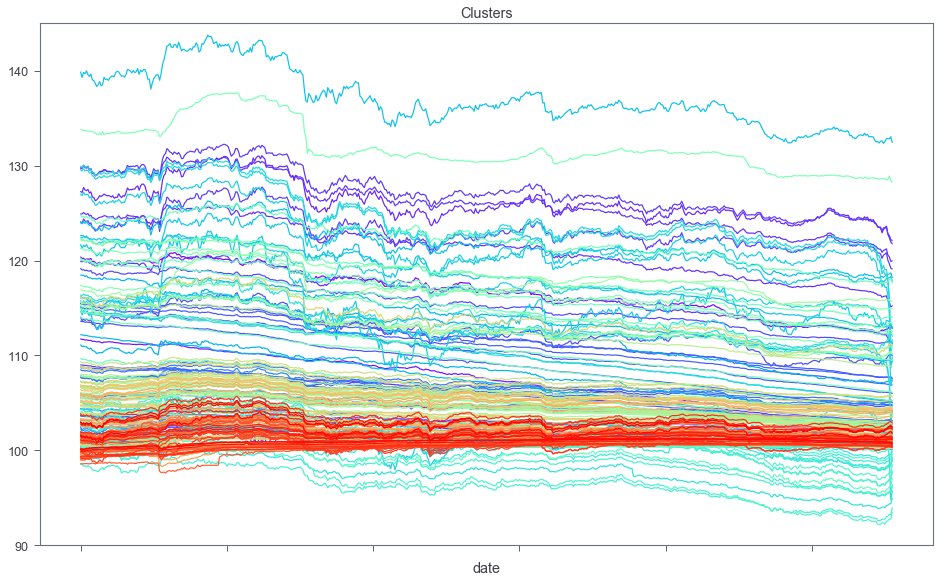

In [41]:
data.plot(c=x, cmap='rainbow', legend=False)
plt.ylim(90, 145)
plt.title("Clusters")
plt.show()

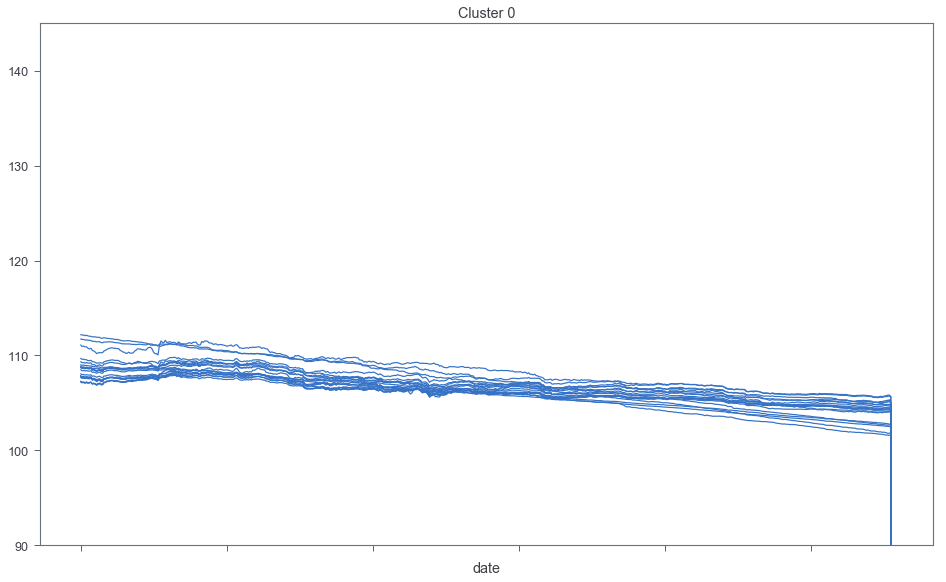

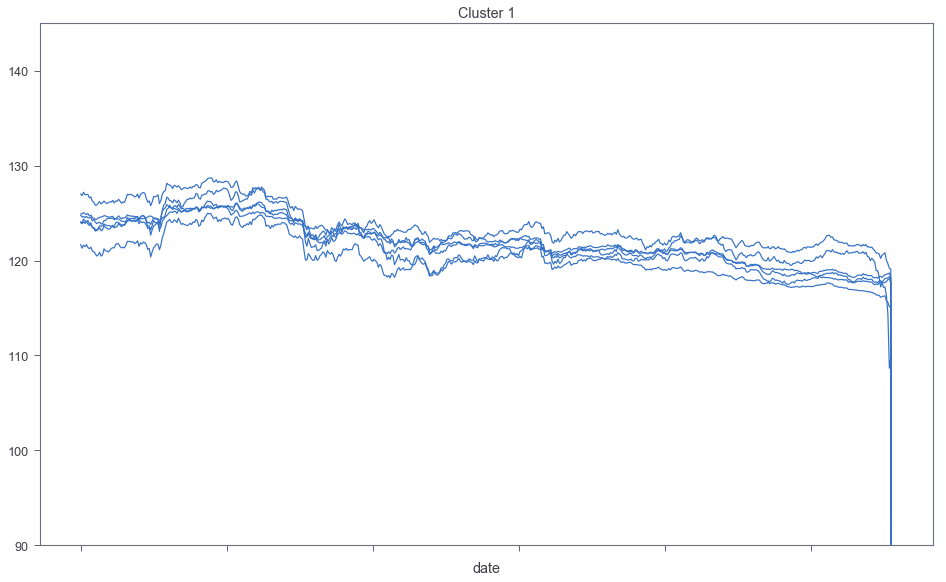

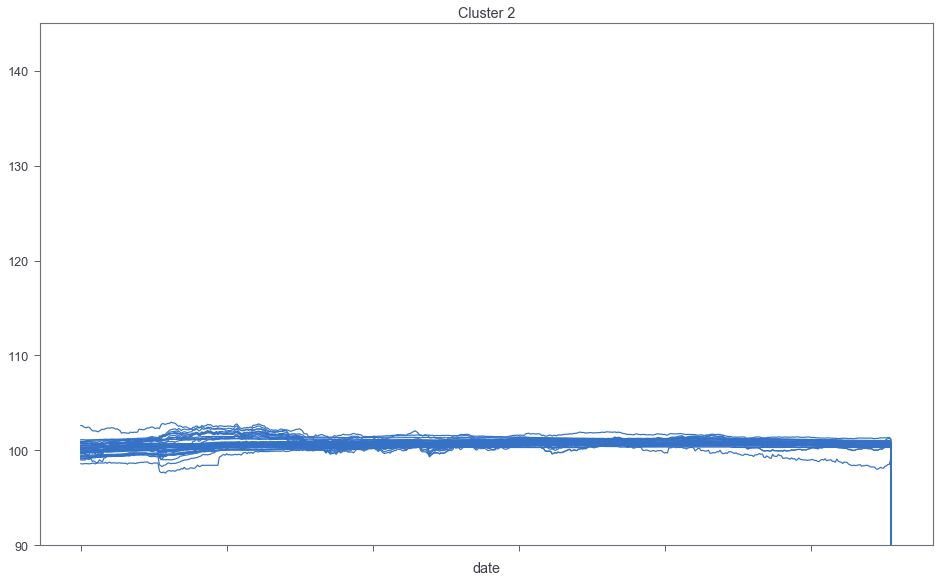

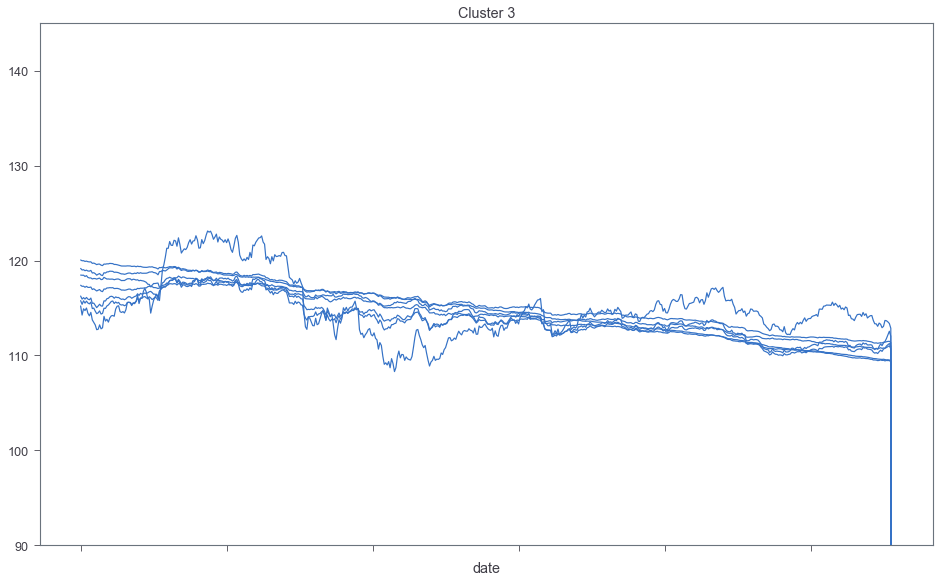

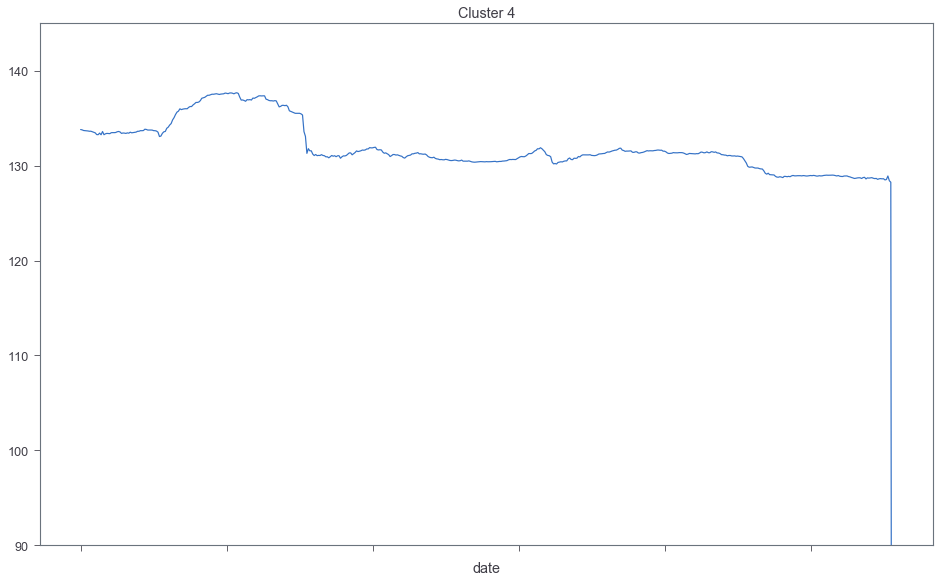

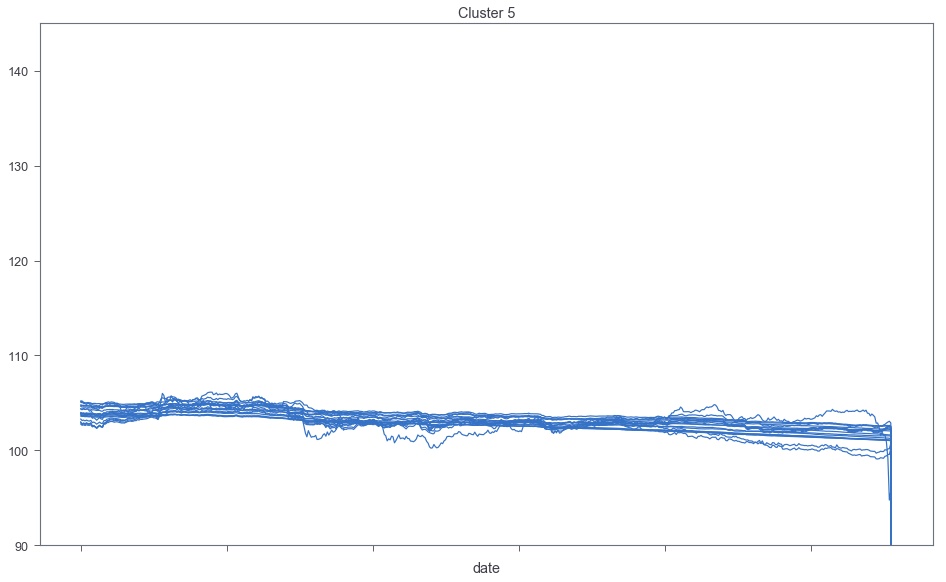

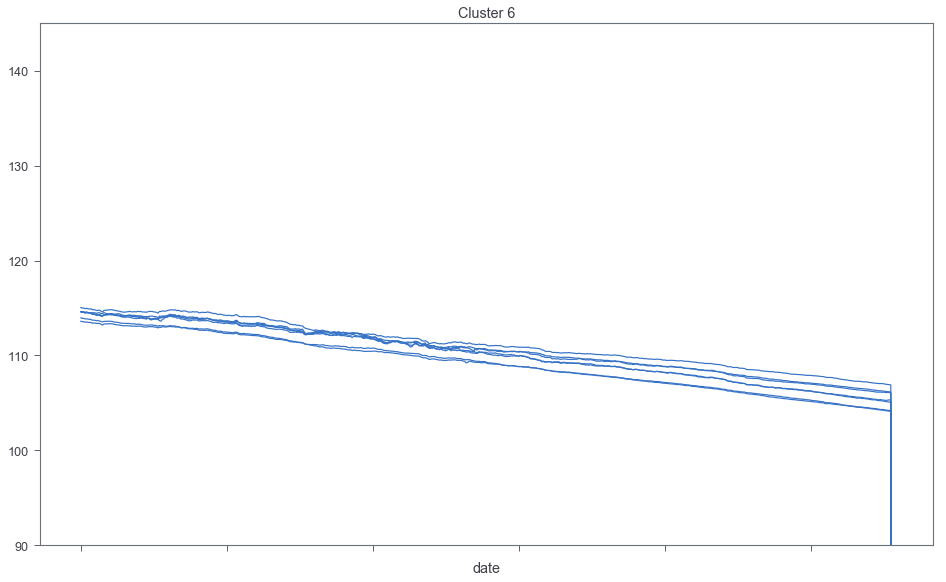

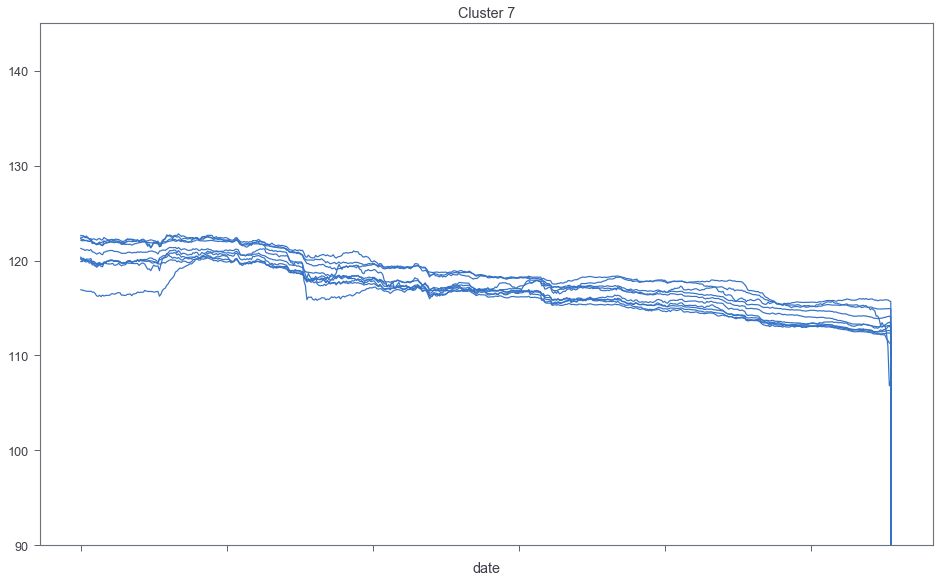

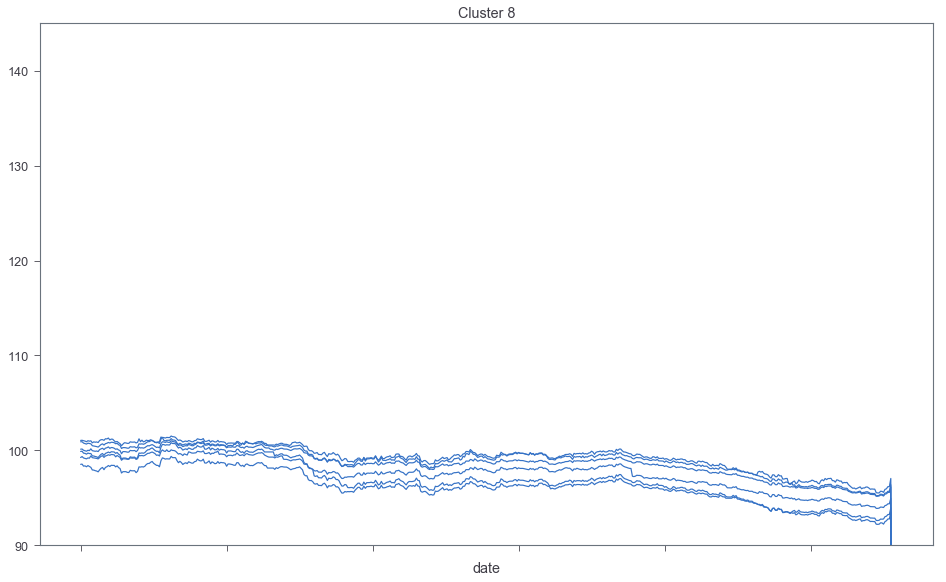

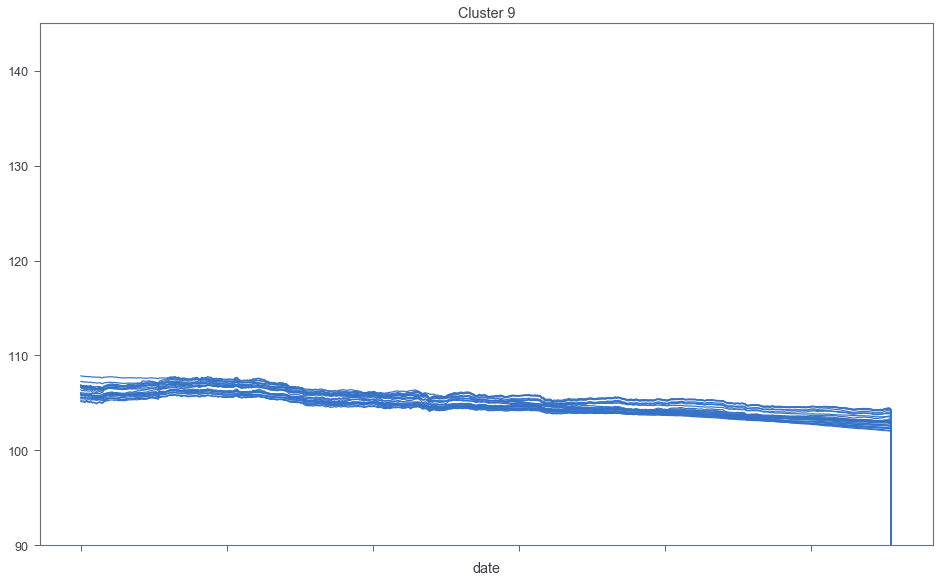

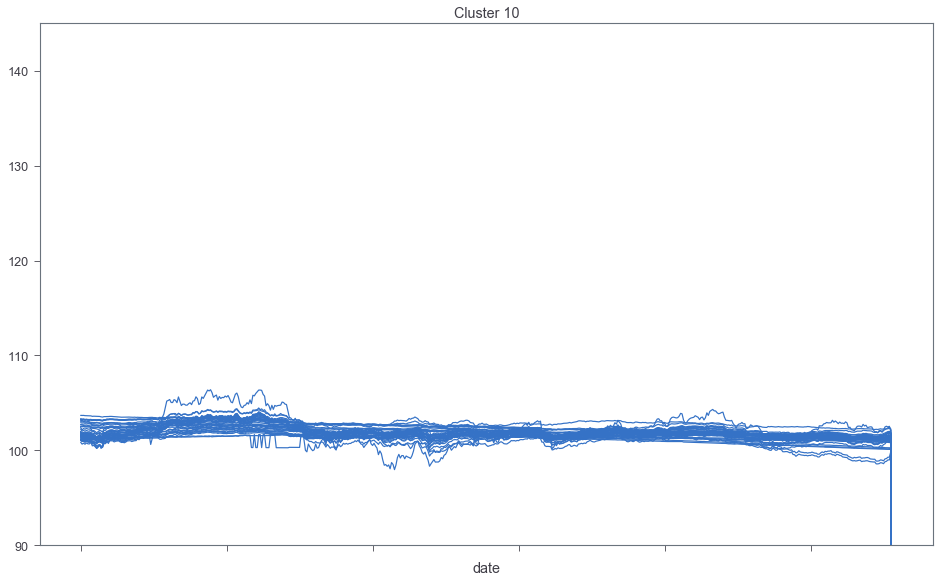

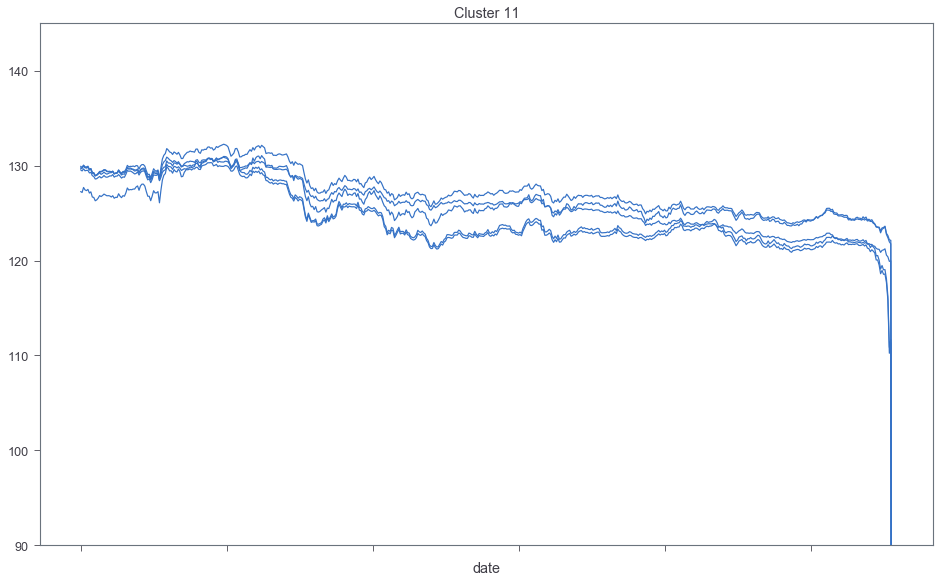

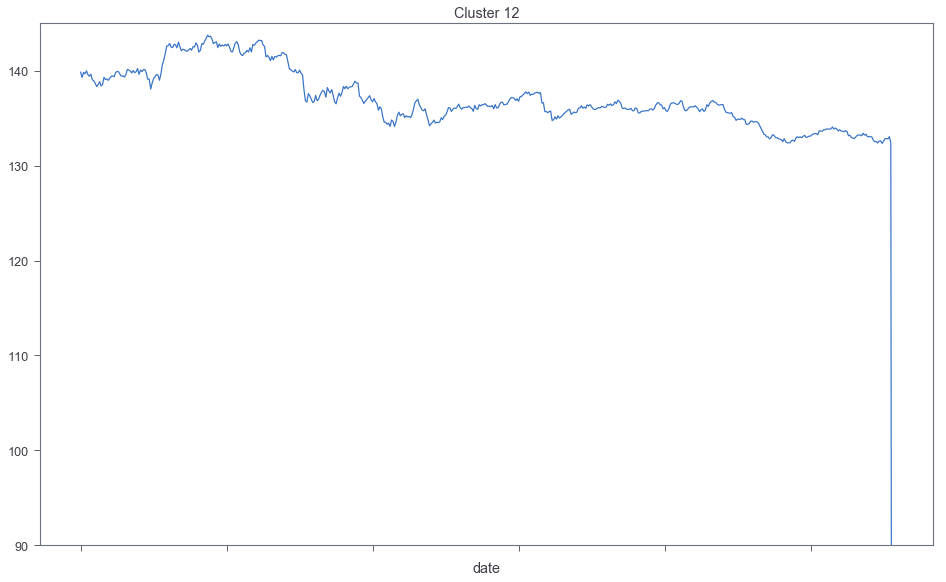

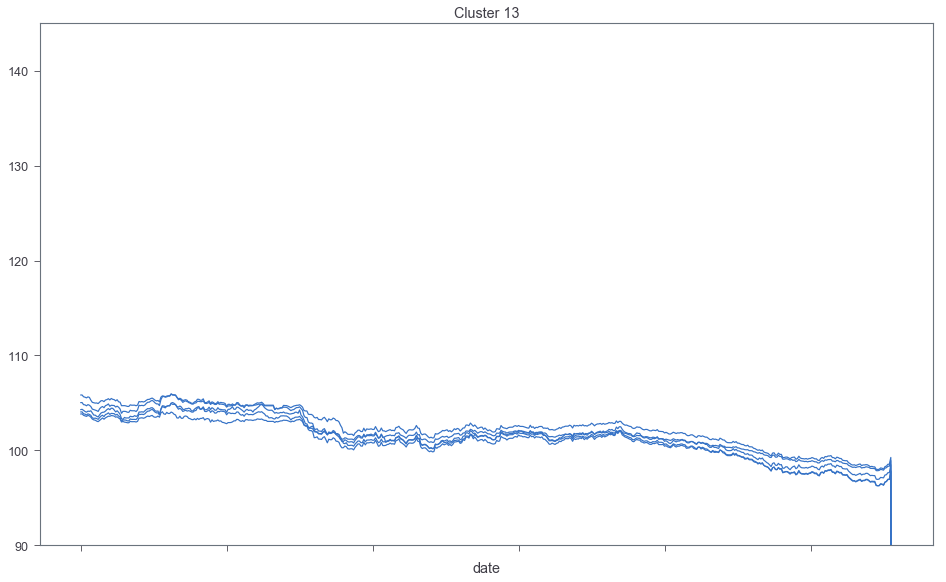

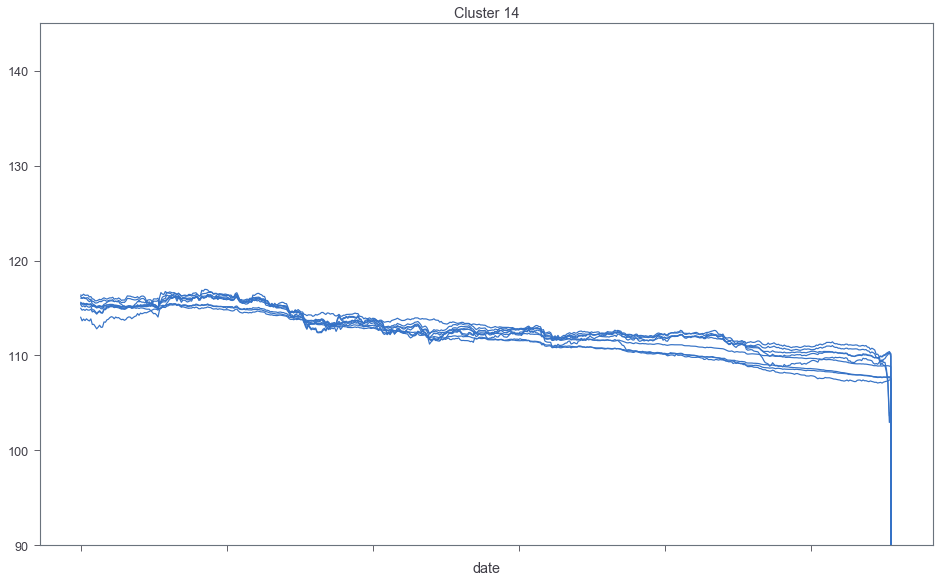

In [42]:
ser = data.T
ser["cluster"] = x
for n, c in enumerate(set(x), start=1):
    ser[ser['cluster'] == c].T.plot(legend=False, c='b')
    plt.title(f"Cluster {c}")
    plt.ylim(90, 145)

    plt.show()

In [ ]:
data[["cluster"]].to_dict()

In [ ]:
data.shape

In [ ]:
x.shape

In [ ]:
ser